In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
%matplotlib inline

## notes ## drx.index = 2015-04-12 12:40:33, ..., 2015-04-12 14:15:46
# no hnu raw data

## interpolation function
def fix(df):
    df.drop_duplicates(subset='datetime', keep='last', inplace=True)
    #df = df.reset_index()
    start = df.datetime.iloc[0]
    end = df.datetime.iloc[-1]
    rng = pd.date_range(start, end, freq='S')
    df1 = df.set_index('datetime')
    df2 = df1.reindex(rng)
    #print df2.head()
    df3 = df2.convert_objects(convert_numeric=True)
    df4 = df3.apply(pd.Series.interpolate)
    #print df3.head()
    return(df4)

def normalize(A):
    A -= A.mean(); A /= A.std()
    return A

def maxccf(A,B):
    nsamples=len(A)
    xcorr = correlate(A, B)
    et = np.arange(1-nsamples, nsamples)
    recovered_time_shift = et[xcorr.argmax()]
    #print recovered_time_shift
    return  recovered_time_shift

def lag(df,lag=0):
    #df = df.set_index('datetime')
    df.index = df.index+pd.offsets.Second(lag)
    return df

dateparse2 = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M:%S')

In [36]:
# read in and fix raw DRX data

drx_raw = pd.read_table('20150412143317_DRX.txt', skiprows=2, header=None, sep='\t', error_bad_lines=False,
                        parse_dates={'datetime': [0]}, date_parser=dateparse2)

drx_raw = pd.DataFrame({'datetime' : drx_raw.datetime,
                                'drxPM1' : drx_raw[2],
                                'drxPM2.5' : drx_raw[3],
                                'drxPM4' :drx_raw[4],
                                'drxPM10' : drx_raw[5],
                                'drxTPM' : drx_raw[6]})
drx = fix(drx_raw)

Skipping line 3605: expected 7 fields, saw 13

C:\Users\XPS\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [37]:
# read in and fix raw Testo data

testo_raw = pd.read_table('20150412143317_Testo350.txt', sep=',', skiprows=2, header=None, 
                          parse_dates={'datetime': [0]}, date_parser=dateparse2)

testo_raw.columns = ['datetime','testoNO_ppm','testoO2_percent','testoCO2i_percent','testoCO_ppm','testoNO2_ppm',
                     'testoSO2_ppm','testoTf_C','testoTa_C','testoPump_Lmin','testoBatt_V','testodP_inW',
                     'testoPabs_hPa','testoCO2_percent','testoMCO2_kgh',
                     'testoPabs_hPa2']

testo = fix(testo_raw)

testo_CO2 = pd.DataFrame({'testo_CO2i' : testo['testoCO2i_percent'],'testo_CO2' : testo['testoCO2_percent']})

testo_CO = pd.DataFrame({'testo_COppm' : testo['testoCO_ppm']})

testo_etc = pd.DataFrame({
                    'testo_O2percent' : testo['testoO2_percent'],
                    'testo_SO2ppm' : testo['testoSO2_ppm'],
                    'testo_Ta_C' : testo['testoTa_C'],
                    'testo_Tf_C' : testo['testoTf_C'],
                    'testo_NOppm' : testo['testoNO_ppm'],
                    'testo_NO2ppm' : testo['testoNO2_ppm'],
                    'testo_Pump_Lmin' : testo['testoPump_Lmin'],
                    'testo_Pabs_hPa2' : testo['testoPabs_hPa2']})

C:\Users\XPS\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [51]:
# merge all the TS together so that they are in the same time window
dfs = [drx, testo_CO2, testo_CO, testo_etc]
big = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
#print big.head()

                     drxPM1  drxPM10  drxPM2.5  drxPM4  drxTPM  testo_CO2  \
2015-04-12 14:33:27   0.012    0.012     0.012   0.012   0.012        0.0   
2015-04-12 14:33:28   0.018    0.018     0.018   0.018   0.018        0.0   
2015-04-12 14:33:29   0.032    0.033     0.032   0.033   0.033        0.0   
2015-04-12 14:33:30   0.072    0.072     0.072   0.072   0.072        0.0   
2015-04-12 14:33:31   0.137    0.137     0.137   0.137   0.137        0.0   

                     testo_CO2i  testo_COppm  testo_NO2ppm  testo_NOppm  \
2015-04-12 14:33:27        0.06         0.20           1.0          8.0   
2015-04-12 14:33:28        0.06         0.55           1.0          8.0   
2015-04-12 14:33:29        0.06         0.90           1.0          8.0   
2015-04-12 14:33:30        0.06         0.90           0.8          5.2   
2015-04-12 14:33:31        0.06         0.90           1.0          5.2   

                     testo_O2percent  testo_Pabs_hPa2  testo_Pump_Lmin  \
2015-04-12 1

In [54]:
# normalize the data 
normed = pd.DataFrame({'drx' : normalize(big['drxPM2.5']),
                    'testo_NOppm' : normalize(big.testo_NOppm),
                    'testo_co' : normalize(big.testo_COppm),
                    'testo_co2' : normalize(big.testo_CO2),
                    'testo_etc' : normalize(big.testo_SO2ppm)})

In [55]:
# find the lags (hint: we went with -12)
# this does nothing but makes DRX a TS
drx = lag(drx)

testo_co2_k = maxccf(normed.drx, normed.testo_co2)
testo_co2_L = lag(testo_CO2,testo_co2_k)
print 'drx lags testo_co2 by', testo_co2_k, 'sec'

testo_etc_k = maxccf(normed.drx,normed.testo_NOppm)
testo_etc_L = lag(testo_etc,testo_etc_k)
print 'drx lags testo_NOppm by', testo_etc_k, 'sec'

drx lags testo_co2 by 0 sec
drx lags testo_NOppm by -13 sec


In [57]:
# merge the laged data 
dfsL = [drx, testo_co2_L, testo_etc_L]

lagged = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfsL)

lagged = pd.DataFrame(lagged, index=drx.index)

lagged = pd.DataFrame({
        'drxPM2.5' : lagged['drxPM2.5'],
        'testo_NOppm' : lagged.testo_NOppm,
        'testo_CO2' : lagged.testo_CO2})

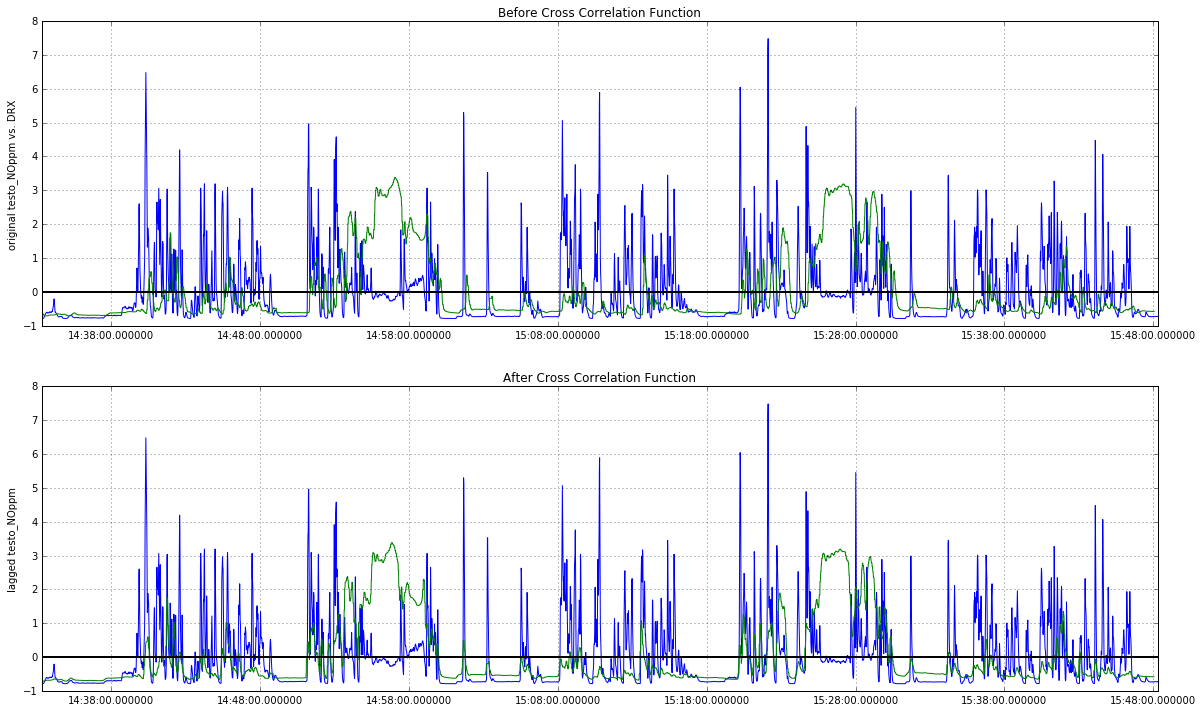

In [71]:
# plotting! (find a way to plot this with out having to normalize?)
old = pd.DataFrame(big, index=lagged.index)

t = lagged.index
y1 = normalize(lagged['drxPM2.5'])
y2 = normalize(old.testo_NOppm)
y3 = normalize(lagged.testo_NOppm)
#plt.title('NOppm versus DRX before lag')
fig = plt.figure(figsize=(20, 12))
#axis, first plot
ax1 = fig.add_subplot(211)
ax1.plot(t, y1)
ax1.plot(t, y2)
ax1.grid(True)
ax1.axhline(0, color='black', lw=2)
plt.ylabel('original testo_NOppm vs. DRX')
plt.title('Before Cross Correlation Function')
## other plot
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(t, y1)
ax2.plot(t, y3)
ax2.grid(True)
ax2.axhline(0, color='black', lw=2)
plt.ylabel('lagged testo_NOppm')
plt.title('After Cross Correlation Function')
plt.show()

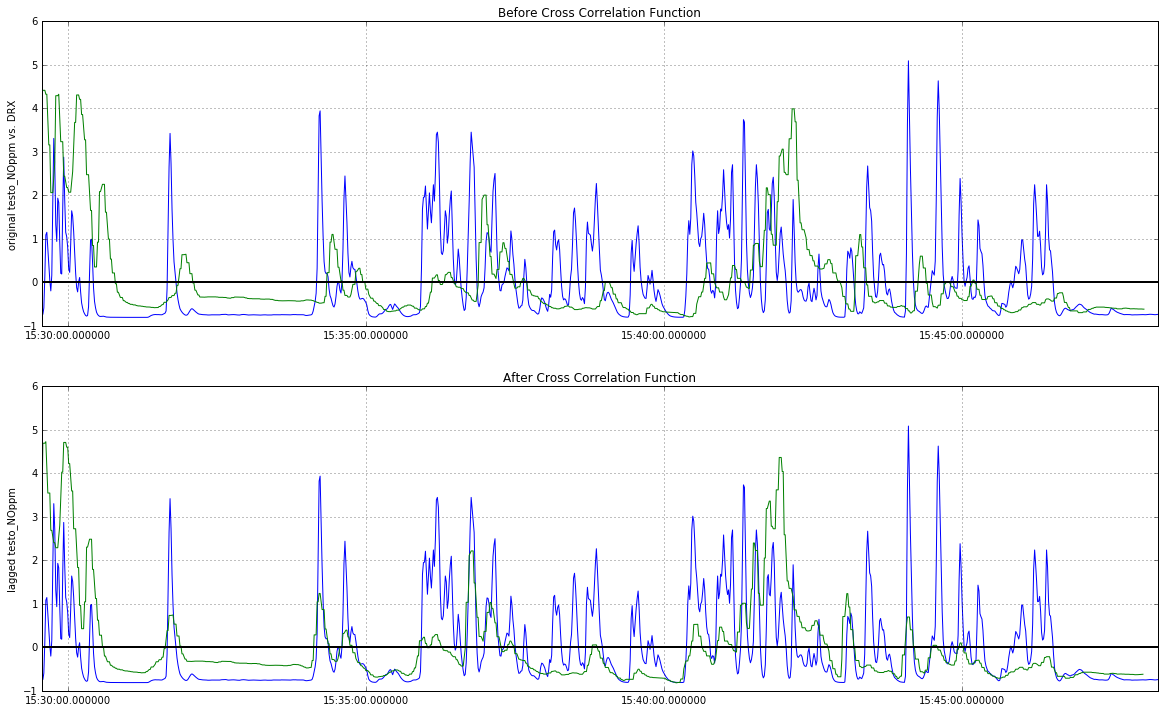

In [70]:
# slicing out a more interesting part
step = len(lagged)/4
lagged_step = lagged[3*step:-1]
old_step = old[3*step:-1]
t = lagged_step.index
y1 = normalize(lagged_step['drxPM2.5'])
y2 = normalize(old_step.testo_NOppm)
y3 = normalize(lagged_step.testo_NOppm)
fig = plt.figure(figsize=(20, 12))
#axis, first plot
ax1 = fig.add_subplot(211)
ax1.plot(t, y1)
ax1.plot(t, y2)
ax1.grid(True)
ax1.axhline(0, color='black', lw=2)
plt.ylabel('original testo_NOppm vs. DRX')
## other plot
plt.title('Before Cross Correlation Function')
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(t, y1)
ax2.plot(t, y3)
ax2.grid(True)
ax2.axhline(0, color='black', lw=2)
plt.ylabel('lagged testo_NOppm')
plt.title('After Cross Correlation Function')
plt.show()